In [1]:
import time
import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import KFold


In [2]:
# scale and normalize input data
def scale(X, X_min, X_max):
    return (X - X_min)/(X_max - X_min)

def normalize(X, X_mean, X_std):
    return (X - X_mean)/X_std

def shuffle_data (samples, labels):
    idx = np.arange(samples.shape[0])
    np.random.shuffle(idx)
    #print  (samples.shape, labels.shape)
    samples, labels = samples[idx], labels[idx]
    return samples, labels

In [3]:
def plots(train_costs, val_costs, test_costs, learning_rate, epochs=1000):
    #Plots
    plt.figure()
    plt.plot(range(epochs), train_costs, label='train costs')
    plt.plot(range(epochs), val_costs, label='val costs')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error')
    plt.title('Training and Validation Errors at Alpha = %.5f'%learning_rate)
    ymin = val_costs.min()
    xmin = np.argmin(val_costs)
    text= "val_lost_min={:.3f}, epoch={:}".format(ymin, xmin)
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="arc3, rad=0")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="center")
    plt.gca().annotate(text, xy=(xmin,ymin), xytext=(0.94,0.6), **kw)
    plt.legend()
    plt.savefig(str(learning_rate) + '_train_val_mse.png')
    plt.show()

    plt.figure()
    plt.plot(range(epochs), test_costs)
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error')
    plt.title('Test Error')
    ymin = test_costs.min()
    xmin = np.argmin(test_costs)
    text= "test_cost_min={:.3f}, epoch={:}".format(ymin, xmin)
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="arc3, rad=0")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="center")
    plt.gca().annotate(text, xy=(xmin,ymin), xytext=(0.94,0.6), **kw)
    plt.savefig(str(learning_rate) + '_test_error.png')
    plt.show()

In [4]:
np.random.seed(10)

epochs = 1000
batch_size = 32
no_hidden1 = 30 #num of neurons in hidden layer 1
learning_rate = 1e-4

floatX = theano.config.floatX


#read and divide data into test and train sets
cal_housing = np.loadtxt('cal_housing.data', delimiter=',')
X_data, Y_data = cal_housing[:,:8], cal_housing[:,-1]
Y_data = (np.asmatrix(Y_data)).transpose()

X_data, Y_data = shuffle_data(X_data, Y_data)

In [5]:

#separate train and test data
m = 3*X_data.shape[0] // 10
testX, testY = X_data[:m],Y_data[:m]
trainX, trainY = X_data[m:], Y_data[m:]

# scale and normalize data
trainX_max, trainX_min =  np.max(trainX, axis=0), np.min(trainX, axis=0)
testX_max, testX_min =  np.max(testX, axis=0), np.min(testX, axis=0)

trainX = scale(trainX, trainX_min, trainX_max)
testX = scale(testX, testX_min, testX_max)

trainX_mean, trainX_std = np.mean(trainX, axis=0), np.std(trainX, axis=0)
testX_mean, testX_std = np.mean(testX, axis=0), np.std(testX, axis=0)

trainX = normalize(trainX, trainX_mean, trainX_std)
testX = normalize(testX, testX_mean, testX_std)


In [6]:
no_features = trainX.shape[1]
x = T.matrix('x') # data sample
d = T.matrix('d') # desired output
no_samples = T.scalar('no_samples')

# initialize weights and biases for hidden layer(s) and output layer
w_o = theano.shared(np.random.randn(no_hidden1)*.01, floatX )
b_o = theano.shared(np.random.randn()*.01, floatX)
w_h1 = theano.shared(np.random.randn(no_features, no_hidden1)*.01, floatX )
b_h1 = theano.shared(np.random.randn(no_hidden1)*0.01, floatX)

# learning rate
alpha = theano.shared(learning_rate, floatX)

#Define mathematical expression:
h1_out = T.nnet.sigmoid(T.dot(x, w_h1) + b_h1)
y = T.dot(h1_out, w_o) + b_o

cost = T.abs_(T.mean(T.sqr(d - y)))
accuracy = T.mean(d - y)

#define gradients
dw_o, db_o, dw_h, db_h = T.grad(cost, [w_o, b_o, w_h1, b_h1])

In [7]:
train = theano.function(
        inputs = [x, d],
        outputs = cost,
        updates = [[w_o, w_o - alpha*dw_o],
                   [b_o, b_o - alpha*db_o],
                   [w_h1, w_h1 - alpha*dw_h],
                   [b_h1, b_h1 - alpha*db_h]],
        allow_input_downcast=True
        )

test = theano.function(
    inputs = [x, d],
    outputs = [y, cost, accuracy],
    allow_input_downcast=True
)

In [8]:
def new_model():
    w_o.set_value(np.random.randn(no_hidden1)*.01)
    b_o.set_value(np.random.randn()*.01)
    w_h1.set_value(np.random.randn(no_features, no_hidden1)*.01)
    b_h1.set_value(np.random.randn(no_hidden1)*.01)

In [9]:
train_cost = np.zeros(epochs)
test_cost = np.zeros(epochs)
test_accuracy = np.zeros(epochs)
val_cost = np.zeros(epochs)
val_accuracy = np.zeros(epochs)

min_error = 1e+15
best_iter = 0
best_w_o = np.zeros(no_hidden1)
best_w_h1 = np.zeros([no_features, no_hidden1])
best_b_o = 0
best_b_h1 = np.zeros(no_hidden1)

alpha.set_value(learning_rate)
print(alpha.get_value())

0.0001


In [1]:
t = time.time()
kf = KFold(n_splits=5)
test_costs = []
train_costs = []
val_costs = []
i=0
for train_index, val_index in kf.split(trainX):
    print("k fold validation: " + str(i))
    val_set_X = trainX[val_index]
    val_set_Y = trainY[val_index]
    train_set_X = trainX[train_index]
    train_set_Y = trainY[train_index]
    new_model()
    for iter in range(epochs):
        if iter % 100 == 0:
            print(iter)

        train_set_X, train_set_Y = shuffle_data(train_set_X, train_set_Y)
        val_set_X, val_set_Y = shuffle_data(val_set_X, val_set_Y)
        train_cost[iter] = train(train_set_X, np.transpose(train_set_Y))
        val_pred, val_cost[iter], val_accuracy[iter] = test(val_set_X, np.transpose(val_set_Y))
        pred, test_cost[iter], test_accuracy[iter] = test(testX, np.transpose(testY))

        if val_cost[iter] < min_error:
            best_iter = iter
            min_error = test_cost[iter]
            best_w_o = w_o.get_value()
            best_w_h1 = w_h1.get_value()
            best_b_o = b_o.get_value()
            best_b_h1 = b_h1.get_value()
#     plots(train_cost, test_cost, learning_rate)        
    test_costs.append(test_cost)
    train_costs.append(train_cost)
    val_costs.append(val_cost)

    #set weights and biases to values at which performance was best
#     w_o.set_value(best_w_o)
#     b_o.set_value(best_b_o)
#     w_h1.set_value(best_w_h1)
#     b_h1.set_value(best_b_h1)

#     best_pred, best_cost, best_accuracy = test(testX, np.transpose(testY))
    best_cost = np.min(test_costs)
    best_accuracy = np.max(test_accuracy)
    best_iter = 2333
    
    print('Minimum error: %.1f, Best accuracy %.1f, Number of Iterations: %d'%(best_cost, best_accuracy, best_iter))
    i += 1
    
plots(np.mean(train_costs, axis=0), np.mean(val_costs, axis=0), np.mean(test_costs, axis=0), learning_rate)



NameError: name 'time' is not defined

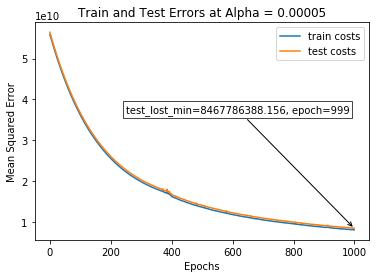

In [58]:
plots(np.mean(train_costs, axis=0), np.mean(test_costs, axis=0), learning_rate)

In [28]:
np.mean(training_errs, axis=0).shape

(1000,)